<a href="https://colab.research.google.com/github/Mukiti-Ryan/Internet_Service_Churn_Prediction_Model/blob/main/Internet_Service_Churn_Prediction_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import Required Libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

**Load the dataset**

In [2]:
df = pd.read_csv('/content/drive/MyDrive/internet_service_churn.csv')

df.shape

(72274, 11)

In [3]:
df.head()

,id,is_tv_subscriber,is_movie_package_subscriber,subscription_age,bill_avg,reamining_contract,service_failure_count,download_avg,upload_avg,download_over_limit,churn
0,15,1,0,11.95,25,0.14,0,8.4,2.3,0,0
1,18,0,0,8.22,0,NaN,0,0.0,0.0,0,1
2,23,1,0,8.91,16,0.00,0,13.7,0.9,0,1
3,27,0,0,6.87,21,NaN,1,0.0,0.0,0,1
4,34,0,0,6.39,0,NaN,0,0.0,0.0,0,1


In [4]:
print(df.dtypes)

id                               int64
is_tv_subscriber                 int64
is_movie_package_subscriber      int64
subscription_age               float64
bill_avg                         int64
reamining_contract             float64
service_failure_count            int64
download_avg                   float64
upload_avg                     float64
download_over_limit              int64
churn                            int64
dtype: object


# **1. Data Cleaning and Grouping**
---

Check for missing values and try to handle them.

In [5]:
df.isna().sum().sum()

22334

This dataset contains several null values.

Let's check which columns have the null values:

In [6]:
null_mask = df.isnull()
null_counts = null_mask.sum()
print("Columns with null values: \n", null_counts[null_counts > 0])

Columns with null values: 
 reamining_contract    21572
download_avg            381
upload_avg              381
dtype: int64


In our case, dropping the null values may not have a huge effect on the results of the model created at the end.

In [7]:
df.dropna(inplace = True)

df.shape

(50375, 11)

# **2. Exploratory Data Analysis**
---
Let's start with the target variable:


In [8]:
df['churn'].value_counts()

0    30044
1    20331
Name: churn, dtype: int64

The target variable has some imbalanced distribution.

It is always beneficial to explore the features **(independent variables)** before trying to build a model.

Let's first discover the features that only have two values:

In [9]:
columns = df.columns
binary_cols = []

for col in columns:
  if df[col].value_counts().shape[0] == 2:
    binary_cols.append(col)

binary_cols 

['is_tv_subscriber', 'is_movie_package_subscriber', 'churn']

The remaining categorical variables have more than two values or classes

In [10]:
multiple_cols = []

for col in df.columns:
  num_unique_vals = df[col].nunique()
  if num_unique_vals > 2:
    multiple_cols.append(col)

multiple_cols

['id',
 'subscription_age',
 'bill_avg',
 'reamining_contract',
 'service_failure_count',
 'download_avg',
 'upload_avg',
 'download_over_limit']

**Binary Categorical Features**

We only have three columns with binary features with one of the columns being our target variable **(Churn)**.

Let's check the class distribution of binary features:

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


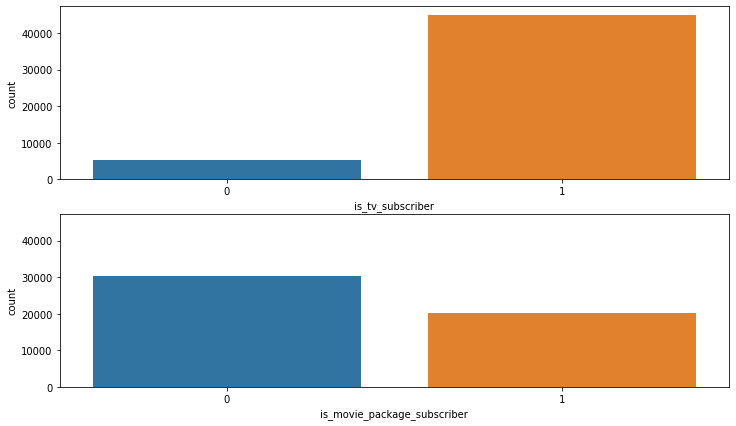

In [11]:
fig, axes = plt.subplots(2, figsize = (12, 7), sharey = True)

sns.countplot("is_tv_subscriber", data = df, ax = axes [0])
sns.countplot("is_movie_package_subscriber", data = df, ax = axes[1])

There is a high imbalance in both the **is_tv_subscriber** and **is_movie_package_subscriber** variables.

It is better to check how the target variable (churn) changes according to the binary features.

Let's see if the churn rate is different for the binary categorical features:

In [12]:
display(df[['is_tv_subscriber', 'churn']].groupby(['is_tv_subscriber']).mean(),
        df[['is_movie_package_subscriber', 'churn']].groupby(['is_movie_package_subscriber']).mean())

,churn
is_tv_subscriber,
0,0.842125
1,0.351529


,churn
is_movie_package_subscriber,
0,0.517009
1,0.232310


Average churn rate for tv subscribers is lower than that of customers who have not subscribed to tv services.

Similarly, the average churn rate for movie package subscribers is lower than that of customers who have not subscribed to movie package services.

**Other Categorical Features**
---
Time to explore other categorical features. 

We also have continuous features such as **subscription_age**, **bill_avg**, **remaining_contract**, **download_avg**, **upload_avg**


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


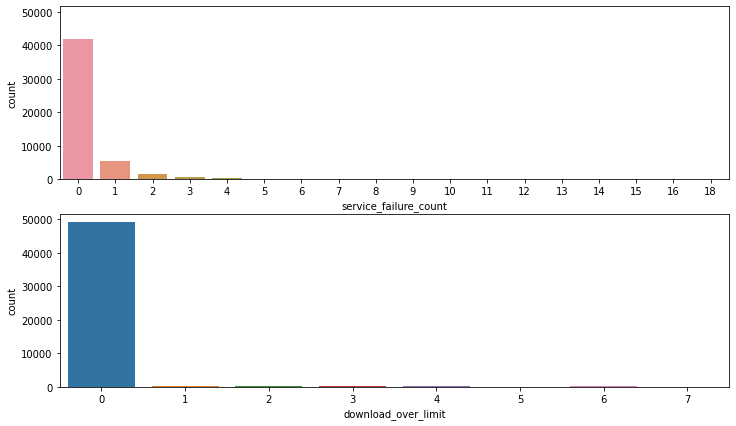

In [13]:
fig, axes = plt.subplots(2, figsize = (12, 7), sharey = True)

sns.countplot('service_failure_count', data = df, ax = axes[0])
sns.countplot('download_over_limit', data = df, ax = axes[1])

In [14]:
display(df[['service_failure_count', 'churn']].groupby(['service_failure_count']).mean(),
        df[['download_over_limit', 'churn']].groupby(['download_over_limit']).mean())

,churn
service_failure_count,
0,0.400919
1,0.390616
2,0.454118
3,0.441221
4,0.514388
5,0.527778
6,0.582090
7,0.558824
8,0.500000


,churn
download_over_limit,
0,0.395629
1,0.517150
2,0.627615
3,0.767296
4,0.856115
5,0.870690
6,0.976378
7,1.000000


**Continuous Featues**
---
The continuous features in this case are **subscription_age**, **bill_avg**, **remaining_contract**, **download_avg**, **upload_avg**

Let's have a look at the distribution of continuous features:


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

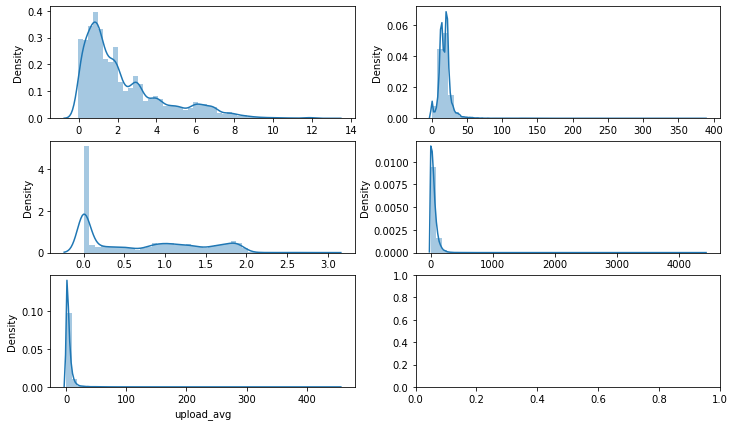

In [15]:
fig, axes = plt.subplots(3, 2, figsize = (12, 7))

sns.distplot(df["subscription_age"], ax = axes[0, 0])
sns.distplot(df["bill_avg"], ax = axes[0, 1])
sns.distplot(df["reamining_contract"], ax = axes[1, 0])
sns.distplot(df["download_avg"], ax = axes[1, 1])
sns.distplot(df["upload_avg"], ax = axes[2, 0])

In [16]:
display(df[['subscription_age', 'churn']].groupby('subscription_age').mean(),
        df[['reamining_contract', 'churn']].groupby('reamining_contract').mean(),
        df[['upload_avg', 'churn']].groupby('upload_avg').mean(),
        df[['bill_avg', 'churn']].groupby('bill_avg').mean(),
        df[['download_avg', 'churn']].groupby('download_avg').mean())

,churn
subscription_age,
-0.02,1.000000
0.00,1.000000
0.01,1.000000
0.02,0.925000
0.03,0.361111
...,...
11.93,0.000000
11.94,0.000000
11.95,0.000000


,churn
reamining_contract,
0.00,0.995600
0.01,0.652452
0.02,0.395770
0.03,0.275676
0.04,0.195455
...,...
2.78,0.000000
2.79,0.000000
2.84,0.000000


,churn
upload_avg,
0.0,0.983007
0.1,0.664220
0.2,0.596123
0.3,0.601983
0.4,0.602410
...,...
327.2,1.000000
373.1,0.000000
392.7,0.000000


,churn
bill_avg,
0,0.940193
1,0.716981
2,0.798742
3,0.734463
4,0.710383
...,...
213,0.000000
221,0.000000
245,1.000000


,churn
download_avg,
0.0,0.997033
0.1,0.762712
0.2,0.727273
0.3,0.673913
0.4,0.750000
...,...
1319.9,0.000000
1396.4,0.000000
1470.3,1.000000


**VARIABLE SELECTION**
---
After exploring the variables, I have decided not to use the following variables because they add little or no informative power to the model.

1. subscription_age
2. bill_avg




In [17]:
df.drop(['id', 'subscription_age', 'bill_avg'], axis = 1, inplace = True)

df.head()

,is_tv_subscriber,is_movie_package_subscriber,reamining_contract,service_failure_count,download_avg,upload_avg,download_over_limit,churn
0,1,0,0.14,0,8.4,2.3,0,0
2,1,0,0.00,0,13.7,0.9,0,1
5,1,1,1.38,0,69.4,4.0,0,0
6,0,0,0.00,0,21.3,2.0,0,1
10,1,1,0.00,0,9.9,1.1,0,1


In [18]:
df.shape

(50375, 8)

# **3. Data Preprocessing**
---
Categorical features need to be converted to numbers so that they can be included in calculations done by a machine learning model. The categorical variables in our dataset are not ordinal (i.e. there is no order in them). 

Therefore we need to encode the variables in a way that each category will be represented by a column and the value in that column will be 0 ir 1. 

The category with higher numbers will be considered more important or effect the model more.

We also need to scale continuous variables. Otherwise, variables with higher values will be given more importance which effects the accuracy of the model.

Encoding categorical variables:


In [19]:
cat_features = ['is_tv_subscriber', 'is_movie_package_subscriber']

X = pd.get_dummies(df, columns = cat_features, drop_first = True)

Scaling continuous variables:

In [20]:
sc = MinMaxScaler()
a = sc.fit_transform(df[['download_over_limit']])
b = sc.fit_transform(df[['service_failure_count']])
c = sc.fit_transform(df[['reamining_contract']])
d = sc.fit_transform(df[['upload_avg']])
e = sc.fit_transform(df[['download_avg']])

X['download_over_limit'] = a
X['service_failure_count'] = b
X['reamining_contract'] = c
X['upload_avg'] = d
X['download_avg'] = e

Let's check the new dimension of the dataset:

In [21]:
X.shape

(50375, 8)

**Resampling**
---
As pointed out earlier, the target variable had an imbalanced class distribution which is not desired for machine learning models. This may impact the model negatively by:

1. Creating bias towards majority class: The model may be biased towards the majority class in the dataset, resulting in poor prediction performance for the minority class. This is because the model may be optimized to predict the majority class, which may be the dominant class in the dataset.

2. Overfitting: The model may overfit the majority class, resulting in poor generalization to new, unseen data. This is because the model may memorize the majority class, leading to poor performance when faced with data from the minority class.

3. Misclassification of minority class: The model may misclassify the minority class as the majority class, leading to poor precision and recall for the minority class. This can be particularly problematic in applications where correctly identifying the minority class is critical, such as fraud detection.

I will use upsampling which means increasing the number of samples of the class with less samples by randomly selecting rows from it.


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Class Distributon Before Resampling')

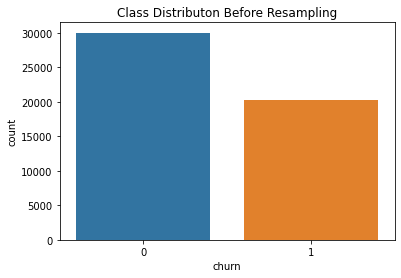

In [22]:
sns.countplot('churn', data = df).set_title('Class Distributon Before Resampling')

Separating the positive class and the negative class

In [23]:
X_no = X[X.churn == 0]
X_yes = X[X.churn == 1]

Upsampling the positive class:

In [24]:
X_yes_upsampled = X_yes.sample(n = len(X_no), replace = True, random_state = 42)

print(len(X_yes_upsampled))

30044


Combining the positive and negative class and checking class distribution

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Class Distribution After Resampling')

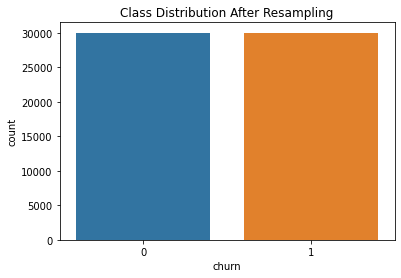

In [25]:
X_upsampled = X_no.append(X_yes_upsampled).reset_index(drop = True)

sns.countplot('churn', data = X_upsampled).set_title('Class Distribution After Resampling')

# **3. Model Creation and Evaluation**
---
We need to divide the dataset into training and test subsets so that we are able to measure the performance of our model on new, previously unseen examples.


In [26]:
# Features (Independent Variables)
X = X_upsampled.drop(['churn'], axis = 1)

# Target (Dependent Variables)
y =  X_upsampled['churn']

Dividing dataset into train and test subsets:

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

**Ridge Classifier**
I have decide to use ridge classifier as a base model. Then I will try a model that I think will perform better.

Let's create a ridge classifier object and train it:

In [28]:
# Create a RidgeClassifier object
clf_ridge = RidgeClassifier()

# Train the model
clf_ridge.fit(X_train, y_train)

RidgeClassifier()

Making predictions on the training set and evaluating:

In [29]:
pred = clf_ridge.predict(X_train)

accuracy_score(y_train, pred)

0.8252132307052216

Making predictions on the test set and evaluating:

In [30]:
pred_test = clf_ridge.predict(X_test)

accuracy_score(y_test, pred_test)

0.8296721584290231

The model has achieved 82% accuracy on both the training and test set. The model is not overfittin because the accuracies on the both set are pretty close.

However, 82% accuracy is not very good so we will try to get a better accuracy using a different model.

**Random Forest**

Let's create a random forest object and train it:

In [31]:
clf_forest = RandomForestClassifier(n_estimators = 100, max_depth = 10)

clf_forest.fit(X_train, y_train)

RandomForestClassifier(max_depth=10)

There are two parameters we need to mention:

1. n_estimators: The number of trees in the forest.
2. max_depth: The maximum depth of the tree

These parameters have critical roles in the accuracy of the model and also preventing the model from overfitting. In general, if we use deep trees(max_depth is very high), the model may end up overfitting.

Making predictions on the training set and evaluating:

In [32]:
pred = clf_forest.predict(X_train)

accuracy_score(y_train, pred)

0.9331807780320366

Making predictions on the test set and evaluating:

In [33]:
pred_test = clf_forest.predict(X_test)

accuracy_score(y_test, pred_test)

0.9297720086536861

The accuracy on the training set is 0.4% higher than the accuracy on the test set which indicates that there might be very slight overfitting. 

We can decrease the depth of a tree in the forest because as trees get deeper, they tend be more specific which results in not generalizing well.

However, reducing tree depth may also decrease the accuracy.

So we need to be careful when optimizing the parameters.

We can also increase the number of trees in the forest which will help the model to be more generalized and thus reduces overfitting.

Parameter tuning is a very crucial part in every project.

Another way is to do cross-validation which allows to use every sample in the training and test set.

# **5. Improving the Model**
---
GridSearchCV is used for hyperparameter tuning in machine learning models. It exhaustively searches over a specified set of hyperparameters and finds the combination that gives the best performance for a given performance metric. This helps in optimizing the model's performance and making it more accurate.

GridSearchCV provides an easy way for parameter tuning. We can do cross-validation and try different parameters using GridSearchCV

Let's create a GridSearchCV object:

In [34]:
parameters = {'n_estimators': [ 250, 300, 350, 400], 'max_depth': [20, 25, 30, 35]}

forest = RandomForestClassifier()

clf = GridSearchCV(estimator = forest, param_grid = parameters, n_jobs = -1, cv = 5)

**CV = 5** means having a **5-fold cross validation**. So dataset is divided into 5 subset. At each iteration, 4 subsets are used in training and other subset is uesd as test set. When 5 iteration completed, the model used all samples as both training and test samples.

**n_jobs** parameter is used to select how many processors to use.

**-1** means using all processors.

In [35]:
clf.fit(X, y)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [20, 25, 30, 35],
                         'n_estimators': [250, 300, 350, 400]})

Let's check the best parameters:

In [36]:
clf.best_params_

{'max_depth': 30, 'n_estimators': 350}

Let's check the overall accuracy:

In [37]:
clf.best_score_

0.9688288404540565